## Importing Data

In [1]:
# import libraries and check versions
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')
    
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


2021-10-12 13:43:50.801220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:43:50.827354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:43:50.827762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:43:50.867975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
import pathlib

directory = './datasets/images'

data_dir = pathlib.Path(directory)

In [3]:
img_count = len(list(data_dir.glob('*/*.png')))

print(img_count)

36000


### Show sample image from dataset

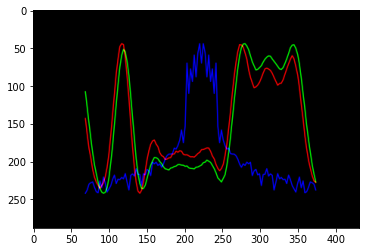

In [6]:
# see image from dataset
BPSK = list(data_dir.glob('BPSK/BPSK_18*'))

image = mpimg.imread(BPSK[0])
plt.imshow(image)

### Open dataset

In [7]:
# open dataset

# define some params for dataset
batch_size = 8
width = 432
height = 288

ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(height, width),
    seed=6969,
    subset='training',
    validation_split=0.2
)

ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(height, width),
    seed=6969,
    subset='validation',
    validation_split=0.2
)

Found 36000 files belonging to 4 classes.
Using 28800 files for training.


2021-10-12 13:44:17.331288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:44:17.331571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:44:17.331788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:44:17.332034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:44:17.332253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 36000 files belonging to 4 classes.
Using 7200 files for validation.


## Exploratory Data Analysis

In [8]:
signal_types = ds_train.class_names

for images, labels in ds_train:
    print(images.shape)
    print(labels.shape)
    break

(8, 288, 432, 3)
(8, 4)


2021-10-12 13:44:18.004315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


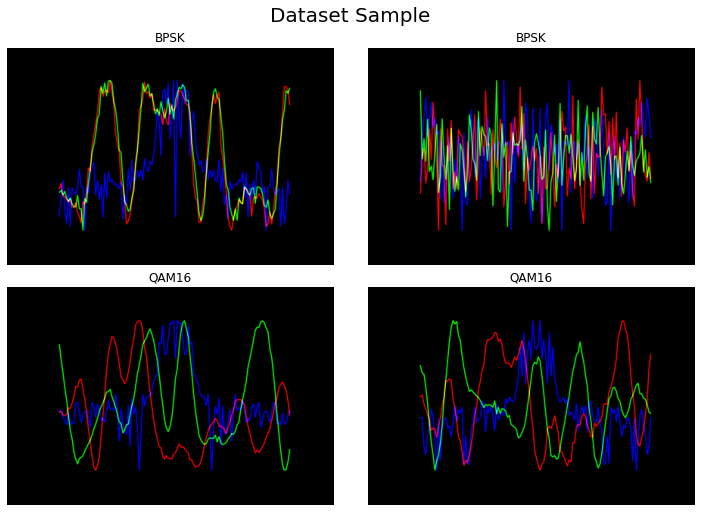

In [9]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
fig.suptitle('Dataset Sample', fontsize=20)

for images, labels in ds_train.take(1):
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(signal_types[np.argmax(labels[i].numpy())])
        ax.axis('off')
        
plt.show()

## Model Creation

In [10]:
# import layers
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Rescaling, Flatten

In [15]:
# create model
model = Sequential()

model.add(Input(shape=(288, 432, 3)))

# normalisation layer for imagery
model.add(Rescaling(1./255))

model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# add flattening layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 288, 432, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 286, 430, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 143, 215, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 141, 213, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 106, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 68, 104, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 52, 64)       

In [17]:
# setup early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# run training
history = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stop])

Epoch 1/50


2021-10-12 13:44:39.886733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-10-12 13:44:40.816758: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 13:44:40.817201: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 13:44:40.817217: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-12 13:44:40.817513: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-12 13:44:40.817548: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-12 13:44:41.604844: I tensorflow/stream_executor/cuda/c

3600/3600 [==============================] - 52s 14ms/step - loss: 0.3732 - accuracy: 0.8417 - val_loss: 0.2820 - val_accuracy: 0.8878
Epoch 2/50
3600/3600 [==============================] - 50s 14ms/step - loss: 0.1617 - accuracy: 0.9353 - val_loss: 0.3368 - val_accuracy: 0.8861
Epoch 3/50
3600/3600 [==============================] - 49s 14ms/step - loss: 0.0670 - accuracy: 0.9749 - val_loss: 0.4006 - val_accuracy: 0.9025
Epoch 4/50
3600/3600 [==============================] - 49s 14ms/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.3635 - val_accuracy: 0.9165
Epoch 5/50
3600/3600 [==============================] - 50s 14ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.4405 - val_accuracy: 0.9224
Epoch 6/50
3600/3600 [==============================] - 50s 14ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.5296 - val_accuracy: 0.9122
Epoch 7/50
3600/3600 [==============================] - 49s 14ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.6917 - val_accura

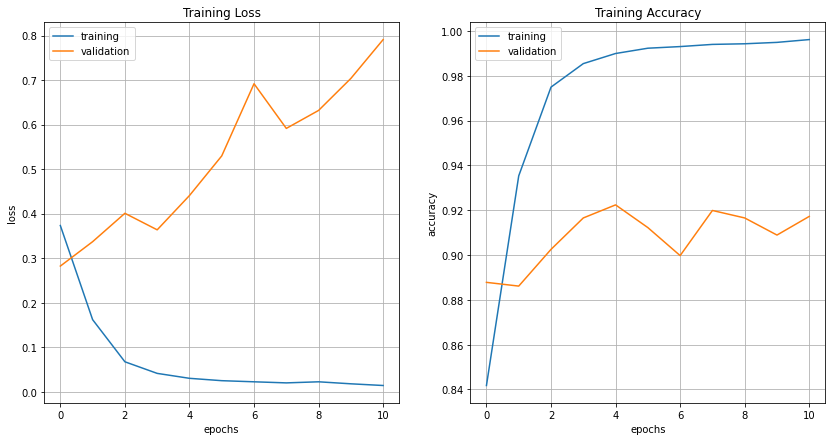

In [19]:
# plot out loss and accuracy graphs
train_hist = history.history

fig = plt.figure(1, figsize=(14, 7))

# loss graph
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_hist['loss'], label='training')
ax1.plot(train_hist['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(b=True)

# accuracy graph
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_hist['accuracy'], label='training')
ax2.plot(train_hist['val_accuracy'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(b=True)

plt.show()

In [20]:
results = model.evaluate(ds_val)

print(f'loss: {results[0]:.3f} | accuracy: {results[1]:.3f}')

900/900 [==============================] - 5s 5ms/step - loss: 0.7909 - accuracy: 0.9172
loss: 0.791 | accuracy: 0.917


[1 3 0 ... 1 3 3] [1 3 0 ... 1 2 3]


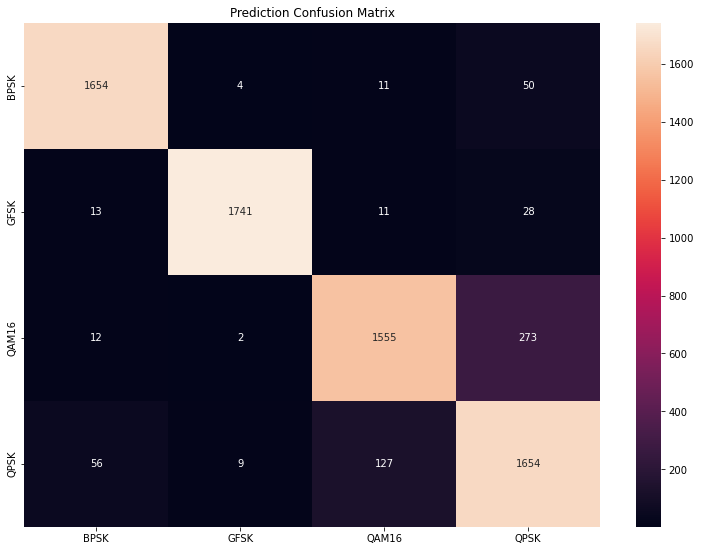

In [38]:
# plot confusion matrices
cm_pred = []
cm_truth = []

# generate predictions
for images, labels in ds_val:
    cm_truth.append(np.argmax(labels, axis=1))
    cm_pred.append(np.argmax(model.predict(images), axis=1))

cm_pred = np.concatenate(cm_pred)
cm_truth = np.concatenate(cm_truth)

# generate matrix
tags = signal_types
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(2, figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title('Prediction Confusion Matrix')

plt.show()